In [12]:
import math
from funcoes import mostrar_secao, arredonda_pra_cima

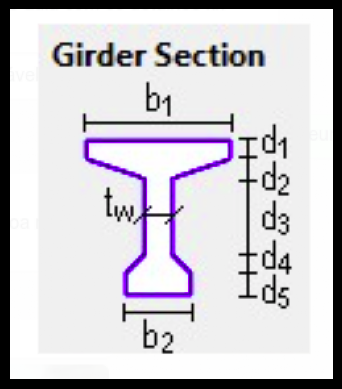

In [13]:
# Dimensões da viga (Seção T) OBS: Verificar secao.png
b1 = 0.40
b2 = 0.40
tw = 0.40

d1 = 0.20
d2 = 0.22
d3 = 1.63
d4 = 0
d5 = 0

mostrar_secao()

In [14]:
# Recobrimento
d_linha = 0.03
d = (d1 + d2 + d3 + d4 + d5) - d_linha

In [15]:
# Concreto
fck = 20e6
fcd = fck / 1.4

In [16]:
# Aço
diametro_bitola = 20  # mm
diametro_bitola_pele = 10  # mm
diametro_estribo = 12.5  # mm
fy = 500e6
fyd = fy / 1.15

In [17]:
# Carregamentos
# Momento fletor
Mg = 1.35 * 0e3
Mq = 1.5 * 1516.536e3
Md = Mg + Mq

# Cortante
Vsg = 1.35 * 6.252e3
Vsq = 1.5 * 483.761e3
Vsd = Vsg + Vsq

In [18]:
# Equação x/d
a = 0.4
b = -1
c = Md / (0.68 * b1 * (d**2) * fcd)

delta = b**2 - 4 * a * c

if delta < 0:
    raise Exception('Dimensões da viga não válidas.')

raiz1 = (-b + math.sqrt(delta)) / (2 * a)
raiz2 = (-b - math.sqrt(delta)) / (2 * a)

epslon = min(raiz1, raiz2)
x = epslon * d
y = 0.8 * x

if y > d1 and not (b1 == b2 == tw):
    raise Exception('Linha neutra fora da mesa.')

In [19]:
# Domínios
dominio = None
if epslon < 0:
    dominio = 1
elif 0 <= epslon <= 0.259:
    dominio = 2
elif 0.259 < epslon <= 0.450:
    dominio = '3a'
elif 0.450 < epslon <= 0.628:
    dominio = '3b'
elif 0.628 < epslon <= 1:
    dominio = 4
elif 1 < epslon:
    dominio = 5
else:
    raise Exception('Intervalo do domínio não definido.')

print(f'x/d={epslon} x={x} y={y} Domínio {dominio}')

x/d=0.15281390179929202 x=0.3086840816345699 y=0.24694726530765593 Domínio 2


In [20]:
# Area de aço
As = Md / (fyd * (d - 0.4 * x))
taxa_armadura = 0.208 / 100
As_min = taxa_armadura * tw * (d + d_linha)

if As_min > As:
    As = As_min
    print(f'Utilizando area de aço mínima')

area_bitola = math.pi * (diametro_bitola / 1e3)**2 / 4
num_bitolas = arredonda_pra_cima(As / area_bitola)

print(f'Area de aço calculado={As}; Area de aço min={As_min} -> {num_bitolas} Ø {diametro_bitola}mm')

Area de aço calculado=0.0027587537352940983; Area de aço min=0.0017055999999999998 -> 9 Ø 20mm


In [21]:
# Armadura de pele
if d1 + d2 + d3 + d4 + d5 >= 0.6:
    As_pele = (0.1 / 100) * tw * (d1 + d2 + d3 + d4 + d5)
    area_bitola = math.pi * (diametro_bitola_pele / 1e3)**2 / 4
    num_bitolas = arredonda_pra_cima(As_pele / area_bitola)

    print(f'Area de aço pele={As_pele} -> {num_bitolas} Ø {diametro_bitola_pele}mm')
else:
    print(f'Não é necessário armadura de pele.')

Area de aço pele=0.00082 -> 11 Ø 10mm


In [22]:
# Verificação do esforço cortante
alfa_v2 = 1 - (fck / 1e6) / 250
Vrd2 = 0.27 * fcd * tw * d
if Vsd <= Vrd2:
    # Não ocorre ruptura das diagonais de compressão. (Vsd<Vrd2)
    # Resistência a compressão do concreto
    fctd = 0.7 * (0.3 * math.pow(fck / 1e6, 2 / 3)) / 1.4
    Vc = 0.6 * fctd * 1e6 * tw * d
    Vsw = Vsd - Vc
    fywd: int = None
    if fyd <= 435e6:
        fywd = fyd
    else:
        fywd = 435e6
    alfa = math.radians(90)
    Asw = Vsw / (0.9 * d * fywd * (math.sin(alfa) + math.cos(alfa)))
    fctm = 0.3 * math.pow(fck / 1e6, 2 / 3)
    fywk = fy
    Asw_min = 0.2 * (fctm * 1e6 / fywk) * tw * math.sin(alfa)

    if Asw < Asw_min:
        Asw = Asw_min

    area_estribo = math.pi * (diametro_estribo / 1e3)**2 / 4
    num_estribos = arredonda_pra_cima(Asw / area_estribo)
    # Espaçamento de estribos
    espacamento_max_estribos: float = None
    if Vsd <= 0.67 * Vrd2:
        if 0.6 * d >= 0.3:
            espacamento_max_estribos = 0.3
        else:
            espacamento_max_estribos = 0.6 * d
    elif Vsd > 0.67 * Vrd2:
        if 0.3 * d >= 0.3:
            espacamento_max_estribos = 0.2
        else:
            espacamento_max_estribos = 0.3 * d
    else:
        raise Exception('Ocorreu um erro no espaçamento de estribos.')

    print(f'Area de aço estribos={Asw}/m; Area de aço min={Asw_min}/m -> {num_estribos} Ø {diametro_estribo}mm')
    print(f'Espaçamento máximo entre estribos={espacamento_max_estribos}')
else:
    raise Exception('Ocorre ruptura das diagonais de compressão.')


Area de aço estribos=0.0003536670238694771/m; Area de aço min=0.0003536670238694771/m -> 3 Ø 12.5mm
Espaçamento máximo entre estribos=0.3
